# Imports 

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Load Dataset
WELFake from HuggingFace

In [4]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 70793
    })
})


## Split dataset

In [5]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
70788  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
70789  You know, because in fantasyland Republicans n...      1           0   
70790  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
70791  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   
70792  Goldman Sachs Endorses Hillary Clinton For Pre...      1           0   

       has_url  percent_uppercase  frequency_punctu

### Train with original 10 features

In [6]:
from sklearn.model_selection import train_test_split

features_orig_10 = ['has_quotes', 'has_url', 'percent_uppercase', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'percent_whitespace', 'avg_sentence_length', 'frequency_punctuation']
seed = 45

y = df["label"]
x = df[features_orig_10]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

       has_quotes  has_url  percent_uppercase  frequency_words_length_15  \
33090           0        0           4.365983                          0   
13814           0        1           2.970607                          1   
47609           0        0           3.880804                          0   
30722           0        0           3.251016                          0   
1945            0        1           2.789491                          0   
...           ...      ...                ...                        ...   
12895           0        1           3.202995                          0   
60960           0        1           2.864939                          0   
6012            0        1          17.731959                          0   
63107           0        0           3.806452                          0   
6558            0        0           5.263158                          0   

       frequency_words_length_14  frequency_words_length_12  \
33090                   

### Training

no further preprocessing

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [8]:
# scale features
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [9]:
# instantiate with default params first
gnb = GaussianNB()
gnb.fit(x_train_scaled, y_train)

GaussianNB()

In [10]:
# predict
y_pred = gnb.predict(x_test_scaled)

In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5755349954092803


In [12]:
# classification report (precision, recall, f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.90      0.68      7006
           1       0.72      0.26      0.38      7153

    accuracy                           0.58     14159
   macro avg       0.63      0.58      0.53     14159
weighted avg       0.63      0.58      0.53     14159



## Visualize feature importance
Feature Importance Formula for GaussianNB:
Feature Importance ≈ |mean₀ − mean₁| / √(var₀ + var₁)

Where:
- mean₀: Mean of feature values for class 0
- mean₁: Mean of feature values for class 1
- var₀: Variance of feature values for class 0
- var₁: Variance of feature values for class 1

This formula captures the difference between class distributions and scales it by how spread out the data is in each class.

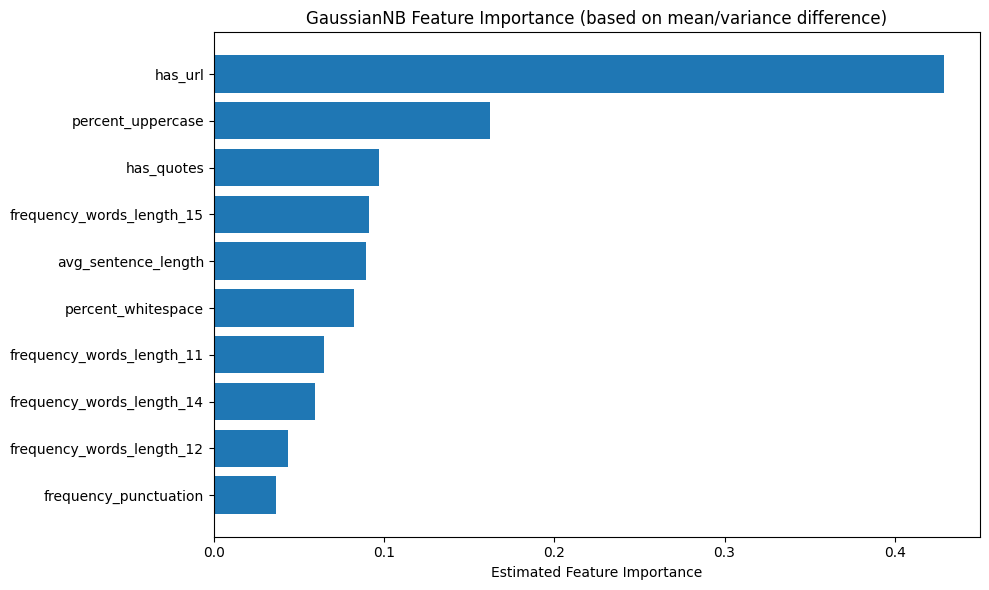

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Feature Importance ≈ |mean₀ − mean₁| / √(var₀ + var₁)
mean_diff = np.abs(gnb.theta_[0] - gnb.theta_[1])  # absolute difference in means
var_sum = np.sqrt(gnb.var_[0] + gnb.var_[1])       # combined std dev
importance_scores = mean_diff / var_sum            # signal-to-noise ratio

# Sort scores and plot
features = x_train.columns
sorted_idx = np.argsort(importance_scores)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importance_scores[sorted_idx])
plt.xlabel("Estimated Feature Importance")
plt.title("GaussianNB Feature Importance (based on mean/variance difference)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Cross Validation

## Hyperparameter Tuning

In [14]:
#randomizedsearchcv - includes cross validation
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'var_smoothing': np.logspace(-11, -7, num=100)  # Try values from 1e-11 to 1e-7
}

rand_search = RandomizedSearchCV(
    gnb,
    param_distributions=param_dist,
    n_iter=5,              
    cv=5,                   
    random_state=seed             
)

# Fit the model on training data
rand_search.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=5,
                   param_distributions={'var_smoothing': array([1.00000000e-11, 1.09749877e-11, 1.20450354e-11, 1.32194115e-11,
       1.45082878e-11, 1.59228279e-11, 1.74752840e-11, 1.91791026e-11,
       2.10490414e-11, 2.31012970e-11, 2.53536449e-11, 2.78255940e-11,
       3.05385551e-11, 3.35160265e-11, 3.67837977e-11, 4.03701726e-11,
       4.43062146...
       1.17681195e-08, 1.29154967e-08, 1.41747416e-08, 1.55567614e-08,
       1.70735265e-08, 1.87381742e-08, 2.05651231e-08, 2.25701972e-08,
       2.47707636e-08, 2.71858824e-08, 2.98364724e-08, 3.27454916e-08,
       3.59381366e-08, 3.94420606e-08, 4.32876128e-08, 4.75081016e-08,
       5.21400829e-08, 5.72236766e-08, 6.28029144e-08, 6.89261210e-08,
       7.56463328e-08, 8.30217568e-08, 9.11162756e-08, 1.00000000e-07])},
                   random_state=45)

In [15]:
# Best model after grid search
gaussian_model = rand_search.best_estimator_
print(f"Best Hyperparameters: {rand_search.best_params_}")

Best Hyperparameters: {'var_smoothing': np.float64(1e-11)}


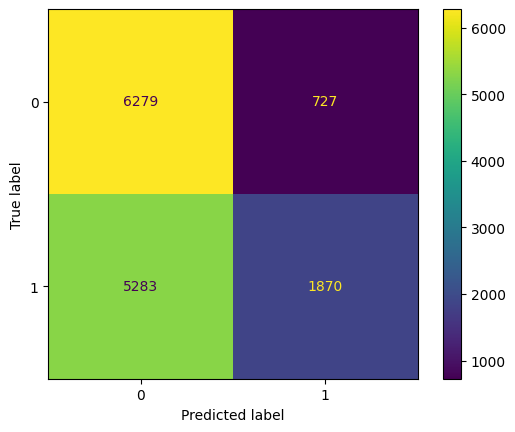

In [ ]:
# Generate predictions with the best model
y_pred_best = gaussian_model.predict(x_test_scaled)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [17]:
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5755349954092803
Precision: 0.7200616095494802
Recall: 0.26142877114497415


## Results on test set

In [18]:
test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test_Stylo")
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 6900
    })
})


In [21]:
test_df = test_dataset["train"].to_pandas()
display(test_df)


y_test_set = test_df["label"]
x_test_set = test_df[features_orig_10]

display(x_test_set)
display(y_test_set)

,text,label,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,The media reported on “5 TikTok dances you can...,0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,"""Over 240,000 'unverified' ballots have alread...",0,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,"Says ""Ron Johnson is making excuses for rioter...",1,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,“We have seen over the last 10 years ... under...,0,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,“I don’t get involved in the hiring and firing...,0,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


,has_quotes,has_url,percent_uppercase,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,percent_whitespace,avg_sentence_length,frequency_punctuation
0,1,0,5.102041,0,1,0,3,17.040816,14.916667,32
1,1,0,3.068897,4,6,26,10,15.636029,18.271186,181
2,1,1,3.742204,0,3,12,7,16.468666,16.619718,224
3,1,1,3.492849,0,2,3,7,16.529153,16.410256,107
4,1,0,3.040541,3,10,1,16,16.394026,19.816327,139
...,...,...,...,...,...,...,...,...,...,...
6895,0,0,7.645260,0,0,0,1,18.042813,20.666667,5
6896,0,0,9.923664,0,0,0,0,16.793893,23.000000,25
6897,0,0,3.754171,0,1,5,1,15.656285,16.216216,94
6898,0,0,3.329065,0,0,0,1,17.669654,18.250000,36


0       0
1       0
2       1
3       0
4       0
       ..
6895    0
6896    0
6897    0
6898    0
6899    0
Name: label, Length: 6900, dtype: int64

In [22]:
# scale features
x_test_set_scaled = scaler.transform(x_test_set)

In [23]:
y_test_pred = gaussian_model.predict(x_test_set_scaled)

In [24]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5127536231884058
Precision: 0.38995726495726496
Recall: 0.782590051457976


## Save best model

In [25]:
import pickle

pickle.dump(gaussian_model, open("models/iter1_gaussian", 'wb'))

In [26]:
#test to see if model can be loaded

loaded_model = pickle.load(open('models/iter1_gaussian', 'rb'))

load_predict = loaded_model.predict(x_test_set_scaled)

accuracy = accuracy_score(y_test_set, load_predict)
precision = precision_score(y_test_set, load_predict)
recall = recall_score(y_test_set, load_predict)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5127536231884058
Precision: 0.38995726495726496
Recall: 0.782590051457976
